Necessary imports


In [ ]:
import os, sys
import pandas as pd

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from packages.bicpy import bicpy
from packages.mylib import myproject
from packages.tcgahandler import LayerDataset
from packages.pydge import pydge
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = "../../data/"

Define necessary variables

In [2]:
# rename dictionary just for aesthetic purposes
rename_dict = {
                "logistic_regression": "Logistic Regression", 
                "random_forest": "Random Forest",
                "svm": "Support Vector Machine",
                "accuracy": "Accuracy",
                "recall": "Recall",
                "precision": "Precision",
                "f1_score": "F1 Score"
                }

# parameterization for biclustering algorithm
# default parameters out of scope for this work
default_param = {
    'symmetries': False,
    'normalization': "column",
    'discretization': "normal_distribution",
    'noise_relaxation': "optional",
    'filling_criteria': "remove",
    'pattern_type': "constant",
    'orientation': "rows",
    'remove_percentage': 0.1, # with only 1 iter doesn't affect
    'balancing': False,
    "to_posthandle": True
}
# relevant parameters defined
params = {"min_biclusters": 10, "min_columns": 3, "min_lift": 1.2, "nr_iterations": 10, "nr_labels": 11, }

# evaluation parameters
# classifiers to test
classifier_list = ['logistic_regression', 'svm', 'random_forest']# DatasetEvaluator.available_classifiers()
# metrics to use
metric_list = ['accuracy', 'recall', 'precision', 'f1_score']
# number of folds for cross-validation
n_folds = 10
# balancing and normalization
balancing, normalization = True, True

# parameters of transformation
# filtering step
filtering = "q10"
filter_by = "lift"
# distance
distance = "norm_euclidean"

# plot variables
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
dpi = 200

# outro
pvalue = 1
target = "vital_status"

Function to train and test classifiers with decreasing dimensionality

In [3]:
def compression_results(project, target, classifier_list, metric_list, parameterization, normalization, 
                                    n_folds,  filter_by, balancing, distance="norm_euclidean", verbose=0):
    """Trains and tests classifiers in datasets transformed with different techniques with decreasing dimensionality
    
    Parameters
    -----------
    project : str
        TCGA project to use
    target : str
        Target variable for the prediction task
    classifier_list : list of str
        Classifiers to train and test
    metric_list : list of str
        Classification metrics used to evaluate the classifiers
    parameterization : dict
        Parameterization for the biclustering algorithm
    normalization : bool
        Flag to normalize data before classification
    n_folds : int
        Number of folds to use in the cross-validation
    filter_by : str
        Metric to filter by in the pattern-based transformation
    balancing : bool
        Flag to balance data before classification
    distance : str
        Distance used to calculate new values of pattern-centric data
    verbose : int
        Verbose flag

    Returns
    --------
    pd.DataFrame
        A DataFrame with the results for each combination of transformation, dimensionality, classifier, metric
    """

    layer = "mrna"
    compressions = [None, 'q3', 'q2', 'q1', 'q10', 'q5']

    dataset = LayerDataset(DATA_DIR, project, layer)
    data = dataset.get_data_with_target(data_type='default', target=target)
    counts = dataset.get_data_with_target(data_type='counts', target=target)
    filtered_genes = pydge.deg_filtering(counts, target, filter_only=True)
    data = dataset.log_transform_data(data, target, data_type="default")

    results = pd.DataFrame()
    dimensionalities = []

    # pattern transformation 
    for comp in compressions:
        pattern_results, shapes = myproject.transform_and_evaluate_validation(parameterization, data[filtered_genes + [target]], target, classifier_list, metric_list,
                                                                    normalization, n_folds, comp, filter_by, balancing, distance,
                                                                    verbose=verbose, return_shapes=True)
        d = [s[1] for s in shapes]
        d = round(statistics.fmean(d))
        pattern_results['dimensions'] = d
        dimensionalities.append(d)
        results = pd.concat([results, pattern_results], ignore_index=True)
    
    # DEG filtering
    for dim in dimensionalities:
        deg_results = myproject.evaluate_validation(data, counts=counts, target=target, pvalue=None, classifier_list=classifier_list,
                                                metric_list=metric_list, normalization=normalization, n_folds=n_folds, balancing=balancing,
                                                n_genes=dim)
        deg_results['dimensions'] = dim
        results = pd.concat([results, deg_results], ignore_index=True)

    # PCA
    for dim in dimensionalities:
        pca_results = myproject.reduce_and_evaluate_validation(data[filtered_genes + [target]], target=target, n_dimensions=dim, reducer_key="PCA",
                                                                classifier_list=classifier_list, metric_list=metric_list, normalization=normalization,
                                                                n_folds=n_folds, balancing=balancing)
        pca_results["dimensions"] = dim
        results = pd.concat([results, pca_results], ignore_index=True)
    

    results = results.sort_values(by=['dataset', 'Metric'], ascending=True)
    return results

In [4]:
project = "TCGA-LGG"
filter_by = 'lift'

parameterization = bicpy.add_default_parameterization(params, default_param)
results = compression_results(project, target, classifier_list, metric_list, parameterization, normalization, 
                                    n_folds,  filter_by, balancing, distance=distance, verbose=1)

No file with values to replace. Continuing.
No file with values to replace. Continuing.
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [180, 190, 248, 328, 270, 209, 229, 717, 216, 259] Mean:  284.6
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [135, 143, 186, 248, 208, 158, 173, 538, 163, 195] Mean:  214.7
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [92, 96, 127, 165, 136, 114, 115, 363, 111, 130] Mean:  144.9
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [47, 51, 63, 87, 69, 56, 60, 180, 55, 66] Mean:  73.4
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [19, 20, 26, 34, 29, 22, 24, 74, 23, 27] Mean:  29.8
pre-transformation pattern data shape:  (514, 24027)
Pattern dimensions:  [10, 11, 14, 19, 16, 12, 15, 40, 12, 14] Mean:  16.3
DGE dimensions:  [285, 285, 285, 285, 285, 285, 285, 285, 285, 285] Mean:  285.0
DGE dimensions:  [215, 215, 215, 215,

Plot

[285, 215, 145, 73, 30, 16]
Accuracy


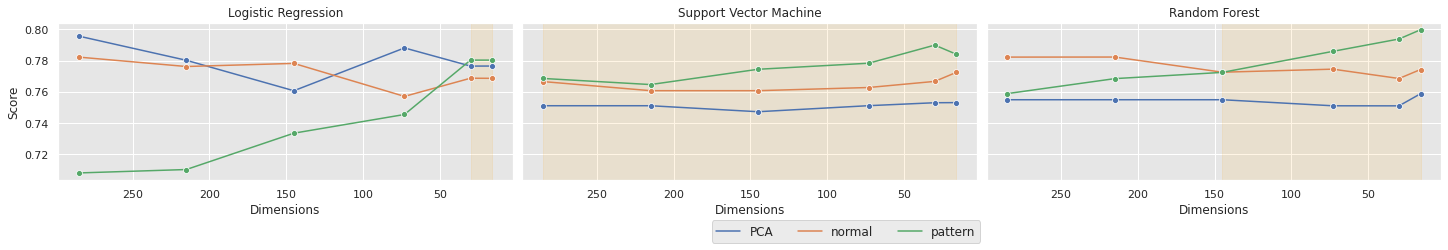

F1 Score


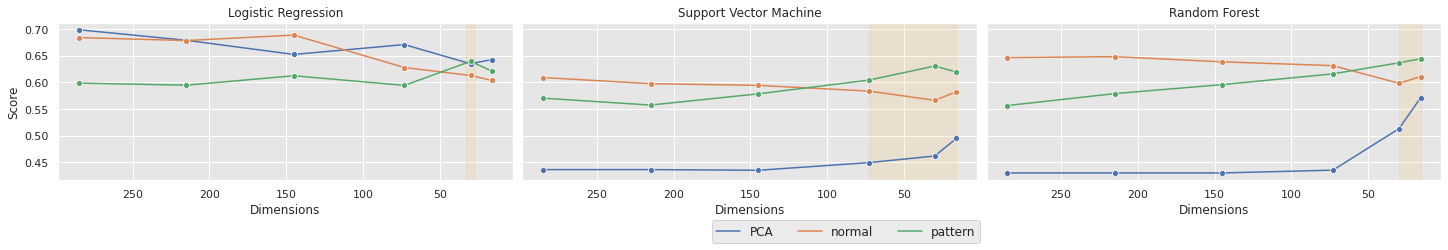

Precision


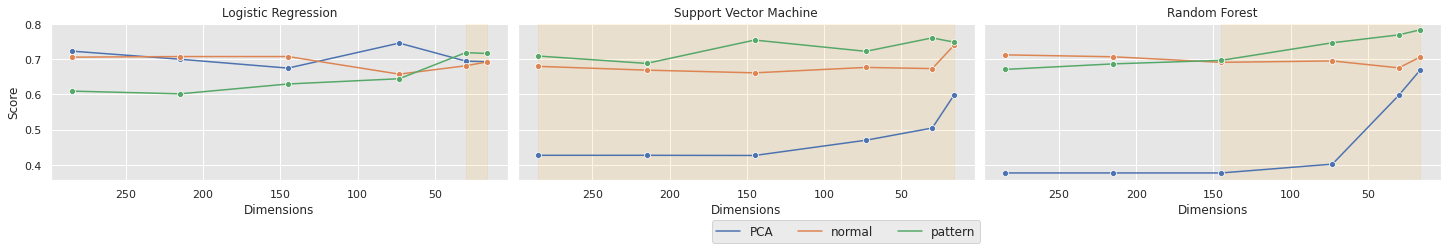

Recall


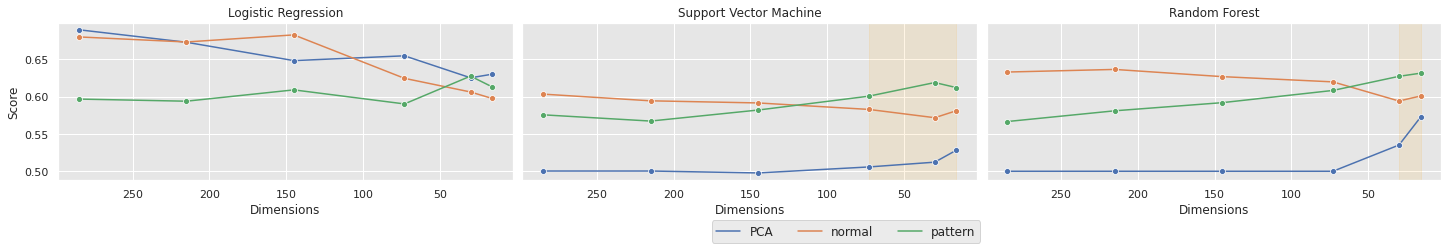

In [5]:
highlight = [(30, 16), (285, 16), (145, 16), (33,27), (73, 16), (30, 16), (30, 16), (285, 16), (145, 16), None, (73,16), (30,16)]

results = results.replace(rename_dict)
sorter = ["DEG Analysis", "Pattern Transformation", "PCA"]
sorterIndex = dict(zip(sorter, range(len(sorter))))
results['dataset_sorter'] = results['dataset'].map(sorterIndex)
results = results.sort_values(["dataset_sorter"])
print(sorted(results["dimensions"].unique(), reverse=True))
# Generate a rank column that will be used to sort
# the dataframe numerically
ci=None
plot_var, x, y, hue = "classifier", "dimensions", "Score", "dataset"
hcounter = 0
for metric in ["Accuracy", "F1 Score", "Precision", "Recall"]:
    print(metric)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 3), constrained_layout=True, sharey='row')
    axes = axes.flatten()

    #title = "Title"
    #fig.suptitle(title, fontsize='x-large')
    for i, plot_title in enumerate(["Logistic Regression", "Support Vector Machine", "Random Forest"]):
        d = results[(results[plot_var] == plot_title) & (results["Metric"] == metric)]
        # display(d[d["dimensions"] == 30].groupby('dataset').mean())
        sns.lineplot(data=d, x=x, y=y, hue=hue, ax=axes[i], errorbar=ci, marker="o")
        #axes[i].legend(ncol=len(results[hue].unique()))
        axes[i].set_title(plot_title)
        axes[i].set_xlabel("Dimensions")

        # if ylim is not None: axes[i].set_ylim(ylim)
        axes[i].invert_xaxis()
        highlight_area = highlight[hcounter]
        hcounter+=1
        if highlight_area is not None:
            axes[i].axvspan(highlight_area[0], highlight_area[1], color='orange', alpha=0.1)
        
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].get_legend().remove()

    fig.legend(handles, labels, bbox_to_anchor=(0.682, 0.025), ncol=len(labels), fontsize='large')

    plt.show()